### PAR-2(GCN4) in cells with abolished cortical flows (Part 2)

As before, but plotting quantification

Dependencies:
- Relies on quantification data generated by _Run/mlc4_quantify.ipynb_


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import bounded_mean_1d, nb_setup, raw_data_path

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

### Analysis functions

In [2]:
def peak_conc(m):
    max_conc = -999999999999
    min_conc = 9999999999
    max_diff = -99999999
    for i in range(len(m)):
        max_conc = max([max_conc, bounded_mean_1d(np.roll(m, i), [0, 0.2])])
        min_conc = min([min_conc, bounded_mean_1d(np.roll(m, i), [0, 0.2])])
        max_diff = max(
            [
                max_diff,
                bounded_mean_1d(np.roll(m, i), [0, 0.2])
                - bounded_mean_1d(np.roll(m, i + len(m) // 2), [0, 0.2]),
            ]
        )
    return max_conc / 1000

### Data

In [3]:
if raw_data_path:
    # Import data
    df = pd.read_csv("../../../data/mlc4_embryos.csv")
    df_quantification = pd.read_csv("../../../data/mlc4_quantification_no_pb.csv")

    # Filter relevant data
    df = df[df.Line.isin(["lp637", "nwg376"])]
    df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]

    # Calculate data for figures
    df_figures = []
    embryo_ids = df_quantification.EmbryoID.unique()
    for embryo_id in embryo_ids:
        df_embryo = df_quantification[df_quantification.EmbryoID == embryo_id]
        df_embryo_grouped = df_embryo.groupby("Frame")
        mems = [i["Membrane signal"].to_numpy() for _, i in df_embryo_grouped]
        mems_peak = [peak_conc(_m) for _m in mems]
        df_embryo_grouped_df = df_embryo_grouped.first().reset_index()[
            ["Frame", "EmbryoID"]
        ]
        df_embryo_grouped_df["mems_peak"] = mems_peak
        df_embryo_grouped_df["EmbryoID"] = embryo_id
        path = raw_data_path + df[df.EmbryoID == embryo_id].Path.iloc[0]
        nebd = np.loadtxt(os.path.join(path, "NEBD.txt")) - 1
        df_embryo_grouped_df["time"] = (
            np.arange(-nebd, len(df_embryo_grouped_df) - nebd) / 2
        )
        df_figures.append(df_embryo_grouped_df)
    df_figures = pd.concat(df_figures, ignore_index=True)

### Plotting functions

In [4]:
def plot_membrane_conc(ax, embryoID):
    df_embryo_grouped_df = df_figures[df_figures.EmbryoID == embryoID]

    if df_embryo_grouped_df["time"].iloc[0] < 0:
        print(embryoID, df_embryo_grouped_df["mems_peak"].iloc[-1])
        ax.plot(
            df_embryo_grouped_df["time"], df_embryo_grouped_df["mems_peak"], linewidth=1
        )


def full_figure(line):
    embryoIDs = df[df.Line == line].EmbryoID

    fig, ax = plt.subplots()
    for e in embryoIDs:
        plot_membrane_conc(ax, e)

    ax.set_xlim(-5, 5)
    ax.tick_params(axis="both", labelsize=8)
    ax.set_xlabel("Time (minutes from NEBD)", fontsize=9)
    ax.set_ylabel("Peak membrane\nconcentration\n(a.u.)", fontsize=8)
    ax.set_ylim(bottom=0, top=45)
    fig.set_size_inches(2.5, 1.5)
    fig.subplots_adjust(bottom=0.3, left=0.27)
    return fig, ax

### Figures

1651762677 43.87831189795918
1651764081 31.14239148571429
1651763515 29.11863453703703
1651765978 18.179147819047618
1651768497 18.777464574766356


/tmp/ipykernel_731/2921809859.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", "", "", ""])


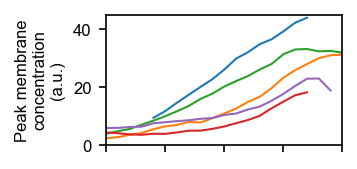

In [5]:
if raw_data_path:
    fig, ax = full_figure("lp637")
    ax.set_xlabel("")
    ax.set_xticklabels(["", "", "", "", ""])
    fig.savefig("Figs/timelapse_quantification_wt.png", dpi=600, transparent=True)
    fig.savefig("Figs/timelapse_quantification_wt.pdf", transparent=True)

1651686192 8.119121098076924
1651689529 10.019581084905658
1651690158 14.390456789215687
1651691673 3.639099456730769
1651692142 7.441865872815535
1651758810 18.500806665137613
1651759099 8.950194278571429
1651761419 8.130890104854368
1651761965 9.89203007979798


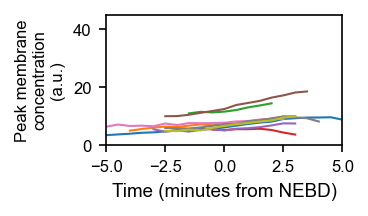

In [6]:
if raw_data_path:
    fig, ax = full_figure("nwg376")
    fig.savefig("Figs/timelapse_quantification_gcn4.png", dpi=600, transparent=True)
    fig.savefig("Figs/timelapse_quantification_gcn4.pdf", transparent=True)

In [7]:
# SourceData
df.merge(df_figures, on="EmbryoID").to_csv(
    "../../../data/EMBO_source_data/4E.csv", index=False
)